# Portfolio Optimization and Parameter Uncertainty
This example illustrates the effect on mean-variance efficient frontiers from purposefully introducing uncertainty in the mean, vol, and correlation.

In [1]:
import numpy as np
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from scipy import stats
from cvxopt import matrix

In [2]:
# Load instrument info
instrument_names, means, covariance_matrix = ft.load_parameters()
vols = np.sqrt(np.diag(covariance_matrix))
correlation_matrix = np.diag(vols**-1) @ covariance_matrix @ np.diag(vols**-1)

In [3]:
# Specify base long-only constraints
I = len(instrument_names)
G = -np.eye(I)
h = np.zeros(I)
mv_opt = ft.MeanVariance(means, covariance_matrix, G, h)

In [4]:
# Parameter uncertainty specification
B = 1000  # Number of efficient frontiers
P = 9  # Number of portfolios used to span the efficient frontiers
N = 100  # Sample size for parameter estimation
np.random.seed(3)  # To avoid numerical instability
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [5]:
# Base frontier with no parameter uncertainty
frontier = mv_opt.efficient_frontier(P)
results = np.full((P, 2), np.nan)
results[:, 0] = means @ frontier
for p in range(P):
    results[p, 1] = frontier[:, p] @ covariance_matrix @ frontier[:, p]

In [6]:
# Mean uncertainty
frontier_mean = np.full((I, P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)
for b in range(B):
    means_run = np.mean(return_sim[:, b, :], axis=0)
    mv_opt._expected_return_row = -matrix(means_run).T
    frontier_mean[:, :, b] = mv_opt.efficient_frontier(P)
    mean_results[:, 0, b] = means @ frontier_mean[:, :, b]
    for p in range(P):
        mean_results[p, 1, b] = frontier_mean[:, p, b] @ covariance_matrix @ frontier_mean[:, p, b]
mv_opt._expected_return_row = -matrix(means).T  # Reset means

In [7]:
# Vol uncertainty
frontier_vol = np.full((I, P, B), np.nan)
vol_results = np.full((P, 2, B), np.nan)
for b in range(B):
    vols_run = np.diag(np.std(return_sim[:, b, :], axis=0))
    cov_matrix_run = vols_run @ correlation_matrix @ vols_run
    mv_opt._P = matrix(1000 * cov_matrix_run)
    frontier_vol[:, :, b] = mv_opt.efficient_frontier(P)
    vol_results[:, 0, b] = means @ frontier_vol[:, :, b]
    for p in range(P):
        vol_results[p, 1, b] = frontier_vol[:, p, b] @ covariance_matrix @ frontier_vol[:, p, b]

In [8]:
# Correlation uncertainty
frontier_cor = np.full((I, P, B), np.nan)
cor_results = np.full((P, 2, B), np.nan)
for b in range(B):
    cor_matrix_run = ft.correlation_matrix(return_sim[:, b, :]).values
    cov_matrix_run = np.diag(vols) @ cor_matrix_run @ np.diag(vols)
    mv_opt._P = matrix(1000 * cov_matrix_run)
    frontier_cor[:, :, b] = mv_opt.efficient_frontier(P)
    cor_results[:, 0, b] = means @ frontier_cor[:, :, b]
    for p in range(P):
        cor_results[p, 1, b] = frontier_cor[:, p, b] @ covariance_matrix @ frontier_cor[:, p, b]

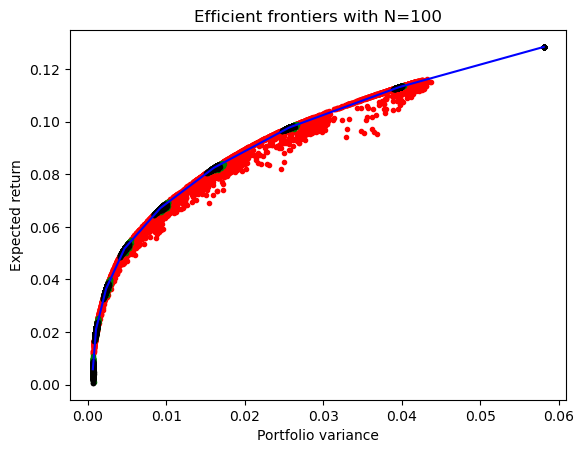

In [9]:
plt.plot(mean_results[:, 1, :], mean_results[:, 0, :], 'r.')
plt.plot(vol_results[:, 1, :], vol_results[:, 0, :], 'g.')
plt.plot(cor_results[:, 1, :], cor_results[:, 0, :], 'k.')
plt.plot(results[:, 1], results[:, 0], 'b-')
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio variance')
plt.show()

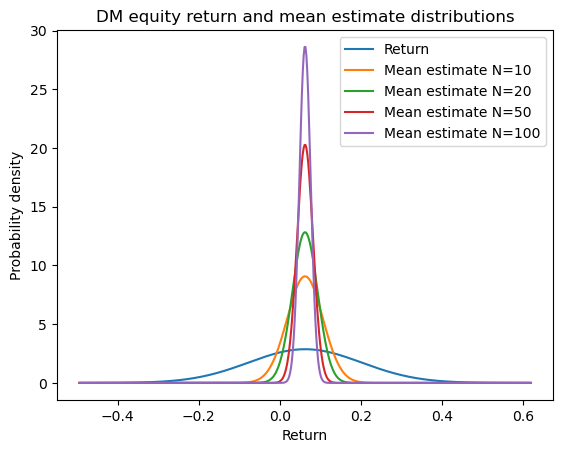

In [10]:
# Visualize mean uncertainty for the different sample sizes
x_min = means[4] - 4 * vols[4]
x_max = means[4] + 4 * vols[4]
x = np.linspace(x_min, x_max, 500)
plt.plot(x, stats.norm.pdf(x, means[4], vols[4]))
plt.plot(x, stats.norm.pdf(x, means[4], vols[4] / np.sqrt(10)))
plt.plot(x, stats.norm.pdf(x, means[4], vols[4] / np.sqrt(20)))
plt.plot(x, stats.norm.pdf(x, means[4], vols[4] / np.sqrt(50)))
plt.plot(x, stats.norm.pdf(x, means[4], vols[4] / np.sqrt(100)))
plt.legend(['Return', 'Mean estimate N=10', 'Mean estimate N=20',
            'Mean estimate N=50', 'Mean estimate N=100'])
plt.title('DM equity return and mean estimate distributions')
plt.ylabel('Probability density')
plt.xlabel('Return')
plt.show()

# License

In [11]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2023 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.